In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from functools import reduce
import os

%matplotlib inline

Useful util functions to prepare data

```python
read_time_series_data(option, data_dir)

transform_df(df, columns_to_drop=["Lat", "Long", "Province/State"])

get_merged_country_data(country, dfs)

list_all_countries(df, country_column)

mobility_per_country(country, gm_report_df)
```

In [2]:
def read_time_series_data(option, data_dir):
    options = ["confirmed", "deaths", "recovered"]
    if option not in options:
        raise KeyError(f"{option} not in the data dir")

    path = os.path.join(data_dir, f"time_series_covid19_{option}_global.csv")
    df = pd.read_csv(path)
    return df


def transform_df(df, columns_to_drop=["Lat", "Long", "Province/State"]):
    """Transform dataframe to required format for analysis
    Params:
        df: Pandas.DataFrame
            dataframe containing the data
        columns_to_drop: list,
            list of columns to remove from the dataframe
            [Lat, Long, Province/State]
    """
    df = df.drop(columns_to_drop, axis=1)
    df = df.groupby("Country/Region").sum().T
    df = df.rename_axis("date")
    df.index = pd.to_datetime(df.index)
    del df.columns.name
    return df


def get_merged_country_data(country, dfs):
    """Perform 3 way merge on confirmed, deaths and recovered dataframes
    on the {country} column
    Params:
        country: string, country to locate
        dfs: dict, containing dataframes of all the data.
    Return:
        df: Pandas.DataFrame, dataframe containing all data
    """

    options = ["confirmed", "deaths", "recovered"]
    for option in options:
        if option not in dfs.keys():
            raise KeyError(f"{option} does not exist in dataframe")

    confirmed = dfs["confirmed"]
    deaths = dfs["deaths"]
    recovered = dfs["recovered"]

    confirmed = confirmed.loc[:, country].to_frame()
    deaths = deaths.loc[:, country].to_frame()
    recovered = recovered.loc[:, country].to_frame()

    confirmed.columns = ["confirmed"]
    deaths.columns = ["deaths"]
    recovered.columns = ["recovered"]

    all_dfs = [confirmed, deaths, recovered]
    df = reduce(
        lambda left, right: pd.merge(
            left, right, right_index=True, left_index=True
        ),
        all_dfs,
    )
    df.index = pd.to_datetime(df.index)
    return df


def list_all_countries(df, country_column):
    """List all countries in dataframe
    Params:
        df: Pandas.DataFrame, dataframe in use
        country_column: string, name of the column containing countries in the dataframe"""
    if country_column in df:
        return list(df[country_column].unique())
    else:
        raise KeyError(f"{country_column} not in dataframe")


def mobility_per_country(country, gm_report_df):
    """Get country data in the mobility dataframe
    Params:
        country: str, name of the country in the df
        gm_report_df: Pandas.DataFrame, dataframe containing mobility report of countries"""

    if country not in list(gm_report_df.country_region.unique()):
        raise KeyError(f"{country} not in dataframe")

    df = gm_report_df[gm_report_df.country_region == country].reset_index(
        drop=True
    )
    df.sub_region_1 = df.sub_region_1.replace(np.nan, "all")
    df = df.set_index("date")
    df.index = pd.to_datetime(df.index)
    df = df.drop(
        ["country_region_code", "country_region", "sub_region_2"], axis=1
    )
    return df


In [3]:
data_dir = 'data/covid/csse_covid_19_data/csse_covid_19_time_series/'
covid_confirmed = read_time_series_data('confirmed', data_dir=data_dir)
covid_recovered = read_time_series_data('recovered', data_dir=data_dir)
covid_deaths = read_time_series_data('deaths', data_dir=data_dir)

In [4]:
covid_confirmed.shape, covid_deaths.shape, covid_deaths.shape

((264, 96), (264, 96), (264, 96))

In [5]:
confirmed = transform_df(covid_confirmed)
deaths = transform_df(covid_deaths)
recovered = transform_df(covid_recovered)

In [6]:
covid_nigeria = get_merged_country_data('Nigeria', dict(confirmed=confirmed, deaths=deaths, recovered=recovered))

In [7]:
covid_nigeria.tail()

,confirmed,deaths,recovered
date,,,
2020-04-18,542,19,166
2020-04-19,627,21,170
2020-04-20,665,22,188
2020-04-21,665,22,188
2020-04-22,873,28,197


In [8]:
# Correct incorrect data on 2020-04-21
covid_nigeria.loc['2020-04-21'] = 782,25,197
covid_nigeria = covid_nigeria.append(pd.DataFrame({'confirmed': covid_nigeria.iloc[-1].confirmed + 108, 'deaths': 31, 'recovered': 197}, index=pd.date_range('2020-04-23', periods=1)))
covid_nigeria.tail()

,confirmed,deaths,recovered
2020-04-19,627,21,170
2020-04-20,665,22,188
2020-04-21,782,25,197
2020-04-22,873,28,197
2020-04-23,981,31,197


In [9]:
def add_new_columns(df):
    """Add new columns based on computed data such as 
    * new_confirmed - new cases added daily
    * active - active cases
    * growth_factor - Growth Factor calculated daily.
    """
    #  Add `new_confirmed` column
    df = df.assign(new_confirmed=lambda x: x.confirmed - x.confirmed.shift(periods=1))
    df = df.fillna(0)
    df['new_confirmed'] = df['new_confirmed'].apply(lambda x: int(x))
    
    #   Add `growth_factor` column
    df = df.assign(growth_factor = lambda x: np.divide(x.new_confirmed, x.new_confirmed.shift(periods=1), \
                                                      out=np.zeros(x.shape[0]), where=x.new_confirmed.shift(periods=1)!=0))
    df = df.fillna(0)
    
    #   Add `active` cases column
    df = df.assign(active=lambda x: x.confirmed - (x.recovered + x.deaths))
    df = df[['confirmed', 'new_confirmed', 'active', 'recovered', 'deaths', 'growth_factor']]
    
    df['date_month_day'] = df.index.strftime('%b %-d')
    return df
    

In [10]:
covid_nigeria = add_new_columns(covid_nigeria)

In [11]:
covid_nigeria.tail()

,confirmed,new_confirmed,active,recovered,deaths,growth_factor,date_month_day
2020-04-19,627,85,436,170,21,1.734694,Apr 19
2020-04-20,665,38,455,188,22,0.447059,Apr 20
2020-04-21,782,117,560,197,25,3.078947,Apr 21
2020-04-22,873,91,648,197,28,0.777778,Apr 22
2020-04-23,981,108,753,197,31,1.186813,Apr 23


In [27]:
sns.set(context='paper', style='darkgrid', palette="Greens_r", font='sans-serif', font_scale=1, color_codes=True, rc=None)

In [28]:
date_of_first_case = '2020-02-28'

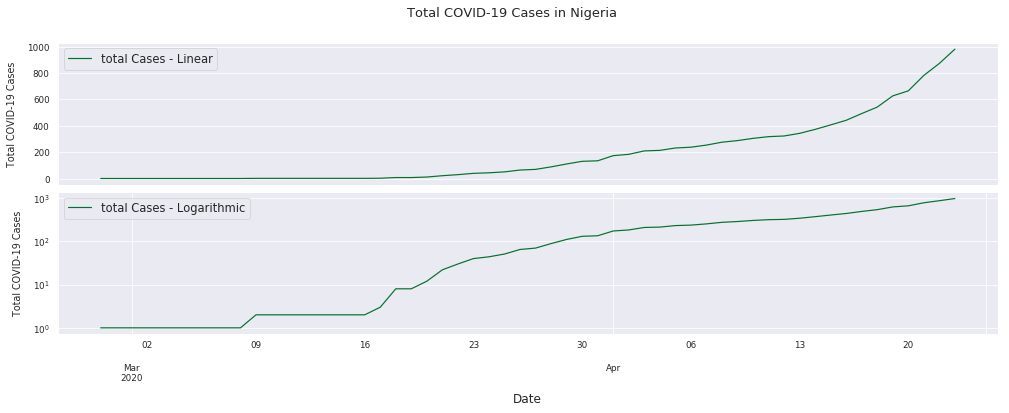

In [47]:
fig, axes = plt.subplots(2,1,figsize=(15,20))

covid_nigeria.loc[date_of_first_case:].confirmed.plot(kind='line', figsize=(15,5), ax=axes[0], label="total Cases - Linear")
covid_nigeria.loc[date_of_first_case:].confirmed.plot(kind='line', figsize=(15,5), logy=True, ax=axes[1], label="total Cases - Logarithmic")
axes[1].legend(fontsize="large")
axes[0].legend(fontsize="large")

plt.subplots_adjust(hspace=0.05)

axes[0].set_xticks([])
axes[0].set_xlabel(' ')
axes[1].set_xlabel('Date', labelpad=10, fontsize=12)

axes[1].set_ylabel('Total COVID-19 Cases', labelpad=10)
axes[0].set_ylabel('Total COVID-19 Cases', labelpad=10)

plt.suptitle('Total COVID-19 Cases in Nigeria', fontsize=13);

In [78]:
covid_nigeria.iloc[0].name

Timestamp('2020-01-22 00:00:00')

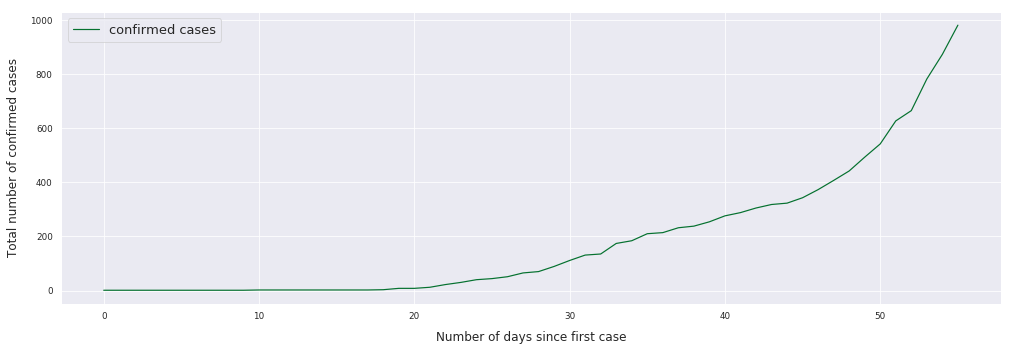

In [106]:
plot = covid_nigeria.loc[date_of_first_case:]
plot = plot.assign(days_since_first_cases = lambda x: (x.index - x.iloc[0].name).days)
fig, ax = plt.subplots(1,1,figsize=(15,5))
sns.lineplot(x='days_since_first_cases', y='confirmed', data=plot, label='confirmed cases', ax=ax)
plt.xlabel('Number of days since first case', labelpad=10, fontsize=12)
plt.ylabel('Total number of confirmed cases', labelpad=10, fontsize=12)
plt.legend(fontsize=13)
plt.savefig('images/evolution_of_cases', bbox_inches='tight')


### Active Cases in Nigeria

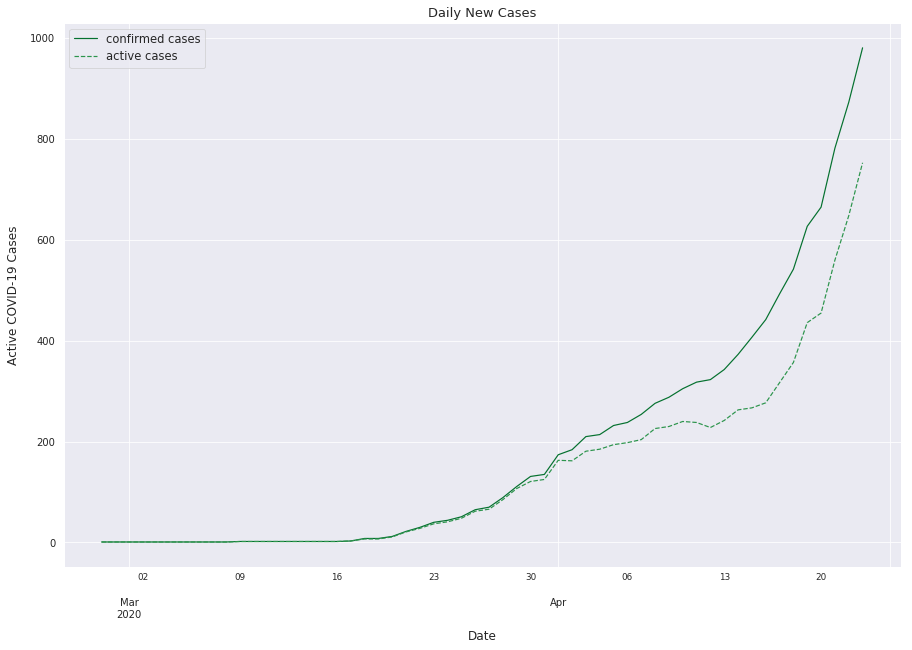

In [254]:
# covid_nigeria.loc[date_of_first_case:].active_cases.plot(kind='line', figsize=(15,5), label="active casess - linear")
fig, ax = plt.subplots(1,1,figsize=(15,10))
covid_nigeria.loc[date_of_first_case:].confirmed.plot(kind="line", label="confirmed cases")
covid_nigeria.loc[date_of_first_case:].active.plot(kind="line", label="active cases", linestyle='--',)

plt.xlabel('Date', fontsize=12, labelpad=10)
plt.xticks(fontsize=10)
plt.ylabel('Active COVID-19 Cases', fontsize=12, labelpad=10)
plt.yticks(fontsize=10);
plt.title('Daily New Cases', fontsize=13);
plt.legend(fontsize='large');

### Daily Cases in Nigeria

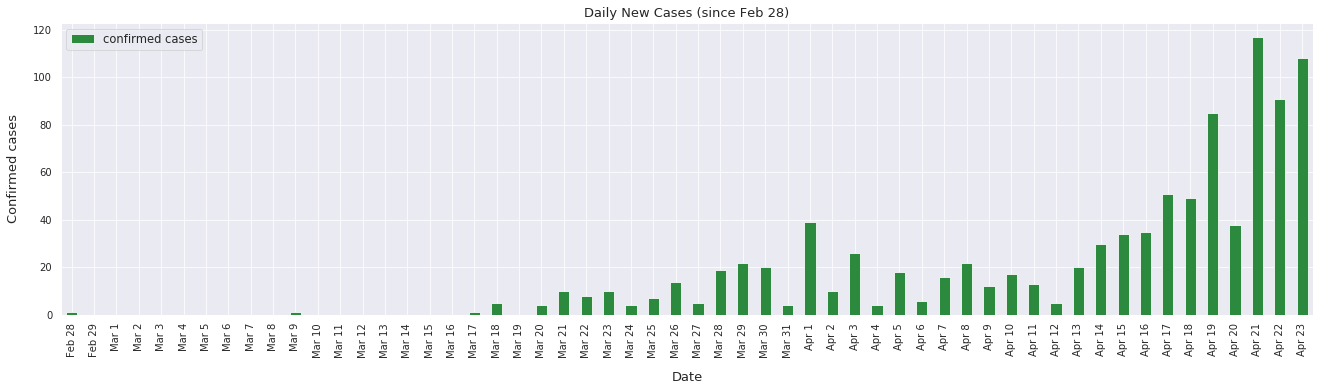

In [110]:
covid_nigeria.loc[date_of_first_case:].set_index('date_month_day').new_confirmed.plot(kind='bar', figsize=(20,5), color='#2b8a3e', label="confirmed cases")
plt.xlabel('Date', fontsize=13, labelpad=13)
plt.xticks(fontsize=10)
plt.ylabel('Confirmed cases', fontsize=13, labelpad=13)
plt.yticks(fontsize=10);
plt.title('Daily New Cases (since Feb 28)',fontsize=13);
plt.legend(fontsize='large');
plt.savefig('images/daily cases barchart - Nigeria', bbox_inches='tight')

### Weekly Cases in Nigeria

In [256]:
march_16 = '2020-03-16'
march = '2020-03'

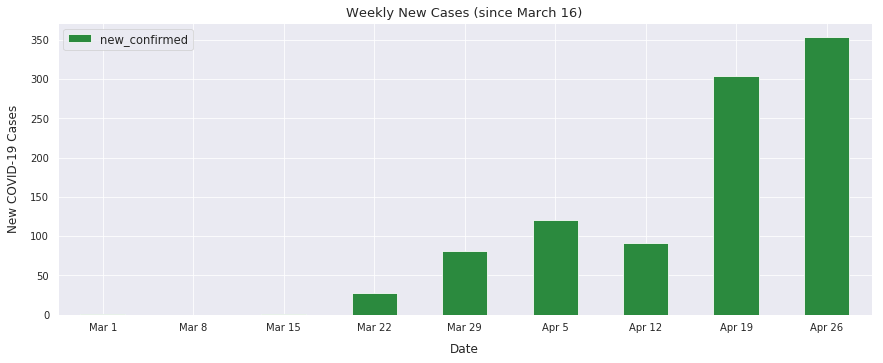

In [111]:
df = covid_nigeria.loc[date_of_first_case:].new_confirmed.resample('1W').sum().to_frame()
df['date_formatted'] = df.index.strftime('%b %-d')
df.set_index('date_formatted').plot(kind='bar', figsize=(13,5), color='#2b8a3e', rot=360, label="confirmed cases") 
plt.xlabel('Date', fontsize=12, labelpad=10)
plt.xticks(fontsize=10)
plt.ylabel('New COVID-19 Cases', fontsize=12, labelpad=10)
plt.yticks(fontsize=10);
plt.title('Weekly New Cases (since March 16)', fontsize=13);
plt.legend(fontsize='large');
plt.savefig('images/weekly cases - Nigeria', bbox_inches='tight')

### Growth Factor
A growth factor above 1 indicates an increase, whereas one which remains between 0 and 1 it is a sign of decline, with the quantity eventually becoming zero, whereas a growth factor constantly above 1 could signal exponential growth

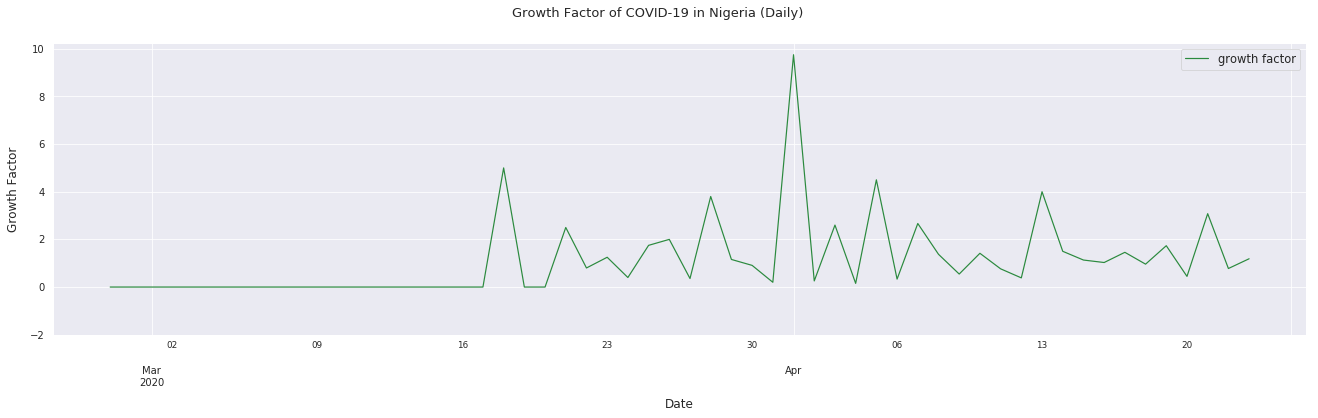

In [150]:
covid_nigeria.loc[date_of_first_case:].growth_factor.plot(kind='line', figsize=(20,5), color='#2b8a3e', label="growth factor")
plt.xlabel('Date', fontsize=12, labelpad=10)
plt.xticks(fontsize=10)
plt.ylabel('Growth Factor', fontsize=12, labelpad=10)
plt.yticks(fontsize=10);
plt.ylim(-2,)
plt.suptitle('Growth Factor of COVID-19 in Nigeria (Daily)', fontsize=13);
plt.legend(fontsize='large');
plt.savefig('images/GF Nigeria - daily', bbox_inches='tight')

#### Growth factor sampled weekly taking the mean

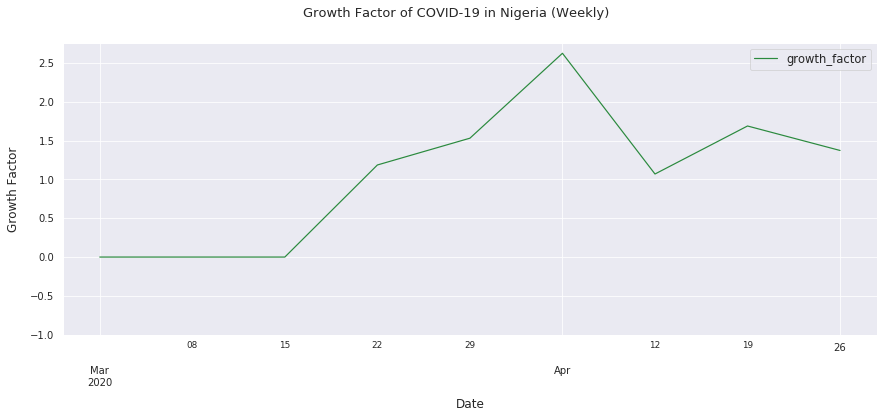

In [152]:
plot = covid_nigeria.loc[date_of_first_case:].growth_factor.resample('1W').mean().to_frame()
plot['date_formatted'] = df.index.strftime('%b %-d')
plot.plot(kind='line', figsize=(13,5), color='#2b8a3e', rot=360, label="growth factor") 

plt.xlabel('Date', fontsize=12, labelpad=10)
plt.xticks(fontsize=10)
plt.ylabel('Growth Factor', fontsize=12, labelpad=10)
plt.yticks(fontsize=10);
plt.ylim(-1,)
plt.suptitle('Growth Factor of COVID-19 in Nigeria (Weekly)', fontsize=13);
plt.legend(fontsize='large');
plt.savefig('images/GF Nigeria - weekly', bbox_inches='tight')

## How does this compare to other parts of the world.

In [153]:
worst_hit_countries = ['US', 'Italy', 'Spain', 'United Kingdom', 'France']
reduced_growth_countries = ['Korea, South', 'Taiwan*','Vietnam', 'New Zealand', 'Australia']
other_countries = ['Canada', 'Georgia', 'Iran', 'Iceland']

In [154]:
worst_hit_covid = {}
for country in worst_hit_countries:
    df = get_merged_country_data(country, dict(confirmed=confirmed, deaths=deaths, recovered=recovered))
    df = add_new_columns(df)
    worst_hit_covid[country] = df

controlled_covid = {}
for country in reduced_growth_countries:
    df = get_merged_country_data(country, dict(confirmed=confirmed, deaths=deaths, recovered=recovered))
    df = add_new_columns(df)
    controlled_covid[country] = df

other_covid = {}
for country in other_countries:
    df = get_merged_country_data(country, dict(confirmed=confirmed, deaths=deaths, recovered=recovered))
    df = add_new_columns(df)
    other_covid[country] = df

In [262]:
print('Controlled: ', controlled_covid.keys())
print('Worst: ', worst_hit_covid.keys())
print('Others: ', other_covid.keys())

Controlled:  dict_keys(['Korea, South', 'Taiwan*', 'Vietnam', 'New Zealand', 'Australia'])
Worst:  dict_keys(['US', 'Italy', 'Spain', 'United Kingdom', 'France'])
Others:  dict_keys(['Canada', 'Georgia', 'Iran', 'Iceland'])


## Total Cases

## Daily Cases

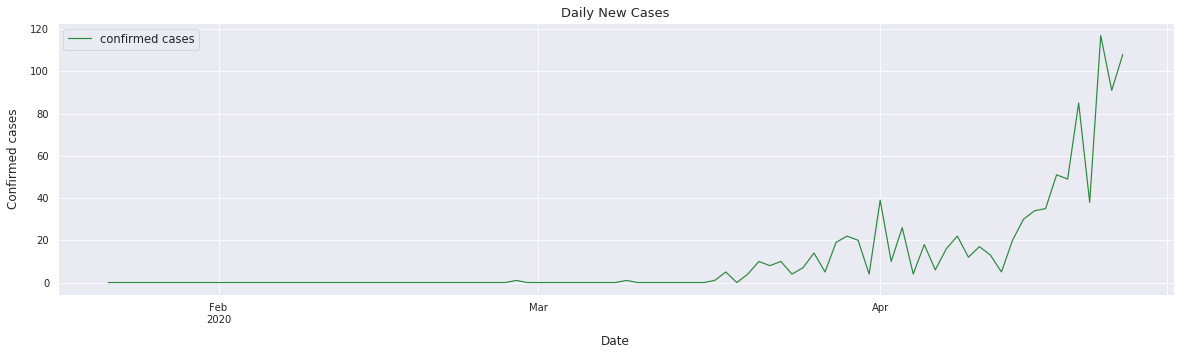

In [263]:
# covid_nigeria.loc[date_of_first_case:].set_index('date_month_day').new_confirmed.plot(kind='line', figsize=(20,5), color='#2b8a3e', label="confirmed cases")
covid_nigeria.new_confirmed.plot(kind='line', figsize=(20,5), color='#2b8a3e', label="confirmed cases")

plt.xlabel('Date', fontsize=12, labelpad=10)
plt.xticks(fontsize=10)
plt.ylabel('Confirmed cases', fontsize=12, labelpad=10)
plt.yticks(fontsize=10);
plt.title('Daily New Cases', fontsize=13);
plt.legend(fontsize='large');
plt.savefig('daily cases - Nigeria')

In [264]:
def normalize(df):
    return df/df.max()

In [265]:
# fig, axes = plt.subplots(3,2)
# axes.ravel()[:3]
import math
math.ceil(len(controlled_covid) / 2)

3

#### Against best performing countries

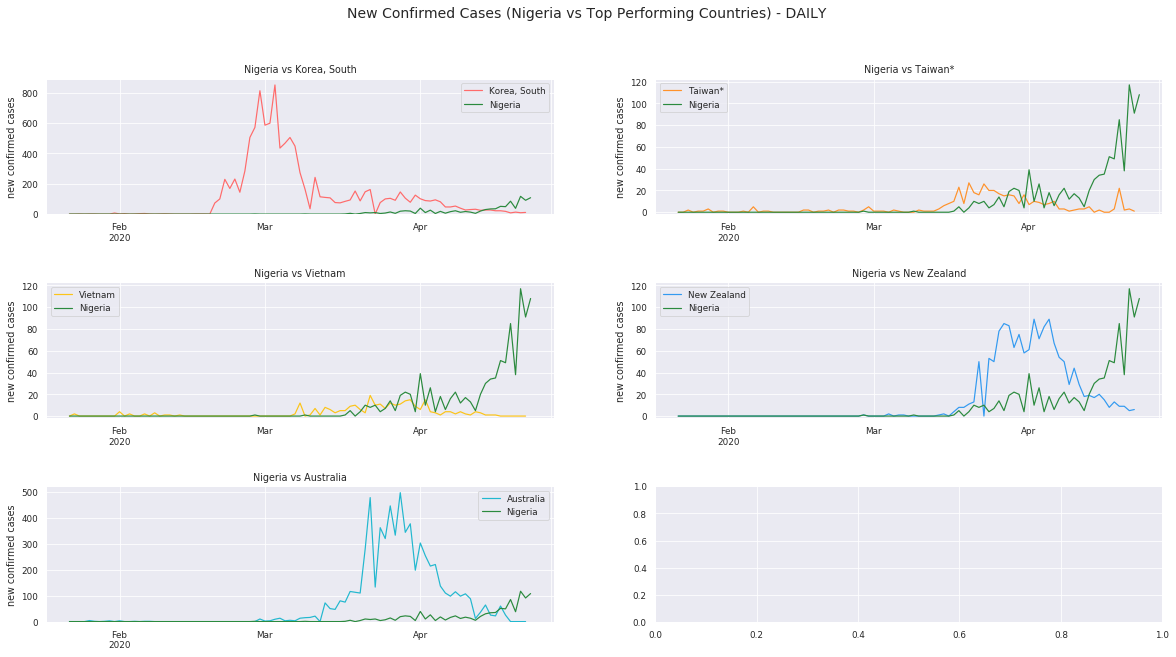

In [267]:
fig, axes = plt.subplots(3,2, figsize=(20,10))
fig.subplots_adjust(hspace=0.5)
axes = axes.ravel()
country_colors = ['#ff6b6b', '#ff922b', '#fcc419', '#339af0', '#22b8cf', '#f06595']
for country, ax in zip(zip(controlled_covid, country_colors), axes):
    df = controlled_covid[country[0]]
    df.new_confirmed.plot(kind='line', ax=ax, color=country[1], label=f'{country[0]}')
    covid_nigeria.new_confirmed.plot(kind='line', ax=ax, color='#2b8a3e', label='Nigeria')
    ax.set_ylim(-2,)
    ax.legend()
    ax.set_xlabel('')
    ax.set_ylabel('new confirmed cases')
    ax.set_title(f'Nigeria vs {country[0]}')
plt.suptitle('New Confirmed Cases (Nigeria vs Top Performing Countries) - DAILY', fontsize='14')
plt.savefig('new-confirmed vs top - daily')

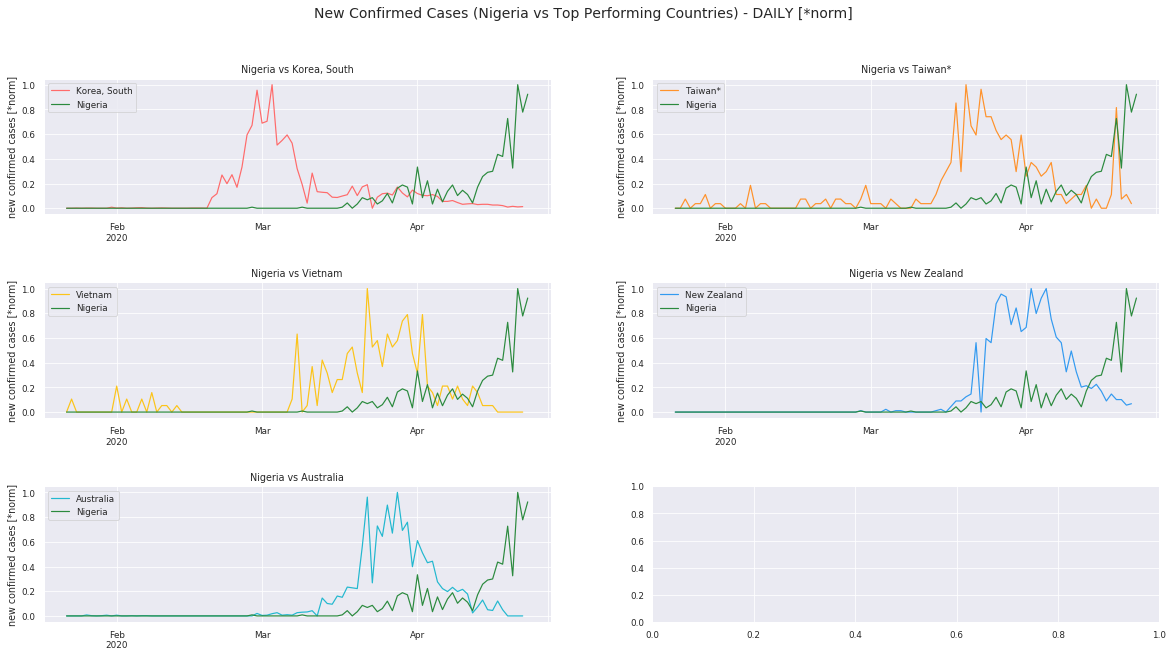

In [268]:
fig, axes = plt.subplots(3,2, figsize=(20,10))
fig.subplots_adjust(hspace=0.5)
axes = axes.ravel()
country_colors = ['#ff6b6b', '#ff922b', '#fcc419', '#339af0', '#22b8cf', '#f06595']
for country, ax in zip(zip(controlled_covid, country_colors), axes):
    df = controlled_covid[country[0]]
    df[['new_confirmed']].assign(norm=lambda x:normalize(x)).norm.plot(kind='line', ax=ax, color=country[1], label=f'{country[0]}')
    covid_nigeria[['new_confirmed']].assign(norm=lambda x: normalize(x)).norm.plot(ax=ax, color='#2b8a3e', label='Nigeria')
    ax.legend()
    ax.set_xlabel('')
    ax.set_ylabel('new confirmed cases [*norm]')
    ax.set_title(f'Nigeria vs {country[0]}')
plt.suptitle('New Confirmed Cases (Nigeria vs Top Performing Countries) - DAILY [*norm]', fontsize=14)
plt.savefig('new-confirmed-norm vs top - daily')

#### Against worst hit countries

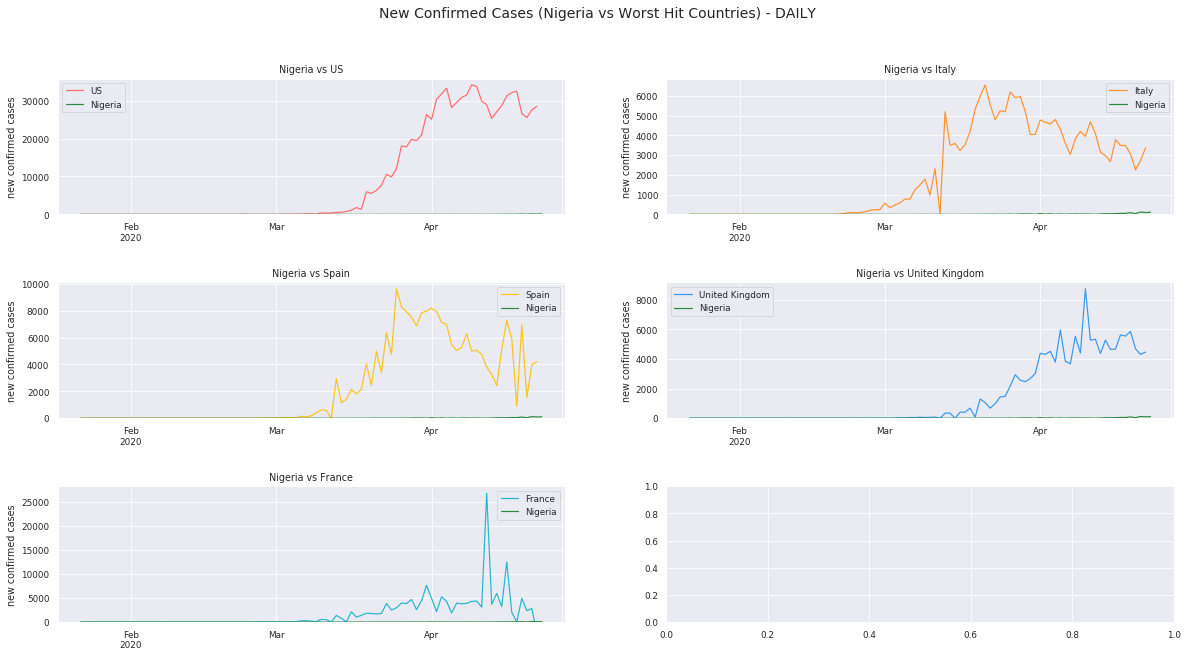

In [269]:
countries = worst_hit_covid

fig, axes = plt.subplots(3,2, figsize=(20,10))
fig.subplots_adjust(hspace=0.5)
axes = axes.ravel()
country_colors = ['#ff6b6b', '#ff922b', '#fcc419', '#339af0', '#22b8cf', '#f06595']
for country, ax in zip(zip(countries, country_colors), axes):
    df = countries[country[0]]
    df.new_confirmed.plot(kind='line', ax=ax, color=country[1], label=f'{country[0]}')
    covid_nigeria.new_confirmed.plot(kind='line', ax=ax, color='#2b8a3e', label='Nigeria')
    ax.set_ylim(-2,)
    ax.legend()
    ax.set_xlabel('')
    ax.set_ylabel('new confirmed cases')
    ax.set_title(f'Nigeria vs {country[0]}')
plt.suptitle('New Confirmed Cases (Nigeria vs Worst Hit Countries) - DAILY', fontsize='14')
plt.savefig('new-confirmed vs worst - daily')

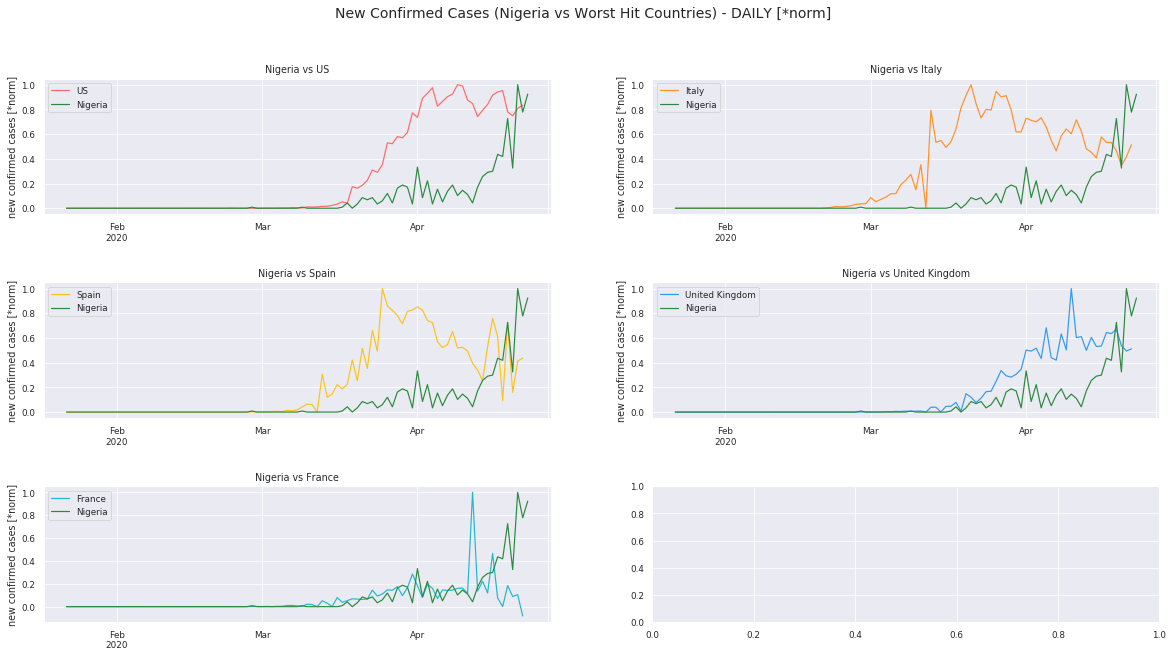

In [270]:
countries = worst_hit_covid

fig, axes = plt.subplots(3,2, figsize=(20,10))
fig.subplots_adjust(hspace=0.5)
axes = axes.ravel()
country_colors = ['#ff6b6b', '#ff922b', '#fcc419', '#339af0', '#22b8cf', '#f06595']
for country, ax in zip(zip(countries, country_colors), axes):
    df = countries[country[0]]
    df[['new_confirmed']].assign(norm=lambda x:normalize(x)).norm.plot(kind='line', ax=ax, color=country[1], label=f'{country[0]}')
    covid_nigeria[['new_confirmed']].assign(norm=lambda x: normalize(x)).norm.plot(ax=ax, color='#2b8a3e', label='Nigeria')
    ax.legend()
    ax.set_xlabel('')
    ax.set_ylabel('new confirmed cases [*norm]')
    ax.set_title(f'Nigeria vs {country[0]}')
plt.suptitle('New Confirmed Cases (Nigeria vs Worst Hit Countries) - DAILY [*norm]', fontsize=14)
plt.savefig('new-confirmed-norm vs worst - daily')

## Weekly Cases

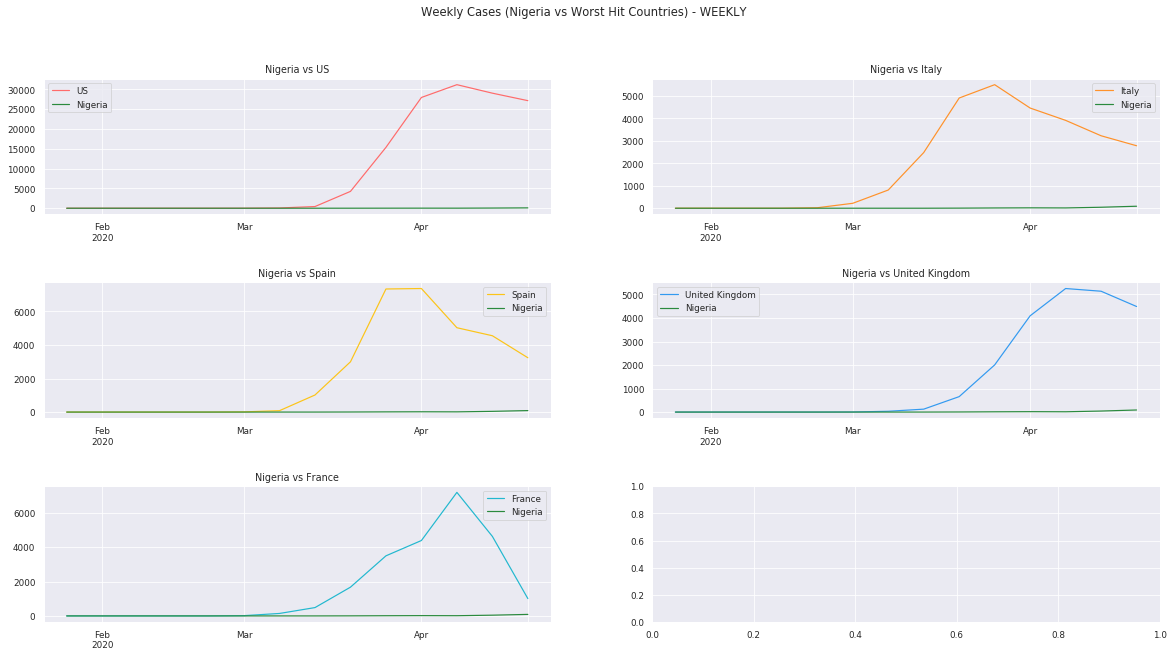

In [271]:
fig, axes = plt.subplots(3,2, figsize=(20,10))
axes = axes.ravel()
fig.subplots_adjust(hspace=0.5)

countries = worst_hit_covid
country_colors = ['#ff6b6b', '#ff922b', '#fcc419', '#339af0', '#22b8cf', '#f06595']
for country, ax in zip(zip(countries, country_colors), axes):
    df = countries[country[0]]
    df.new_confirmed.resample('1W').mean().plot(kind='line', ax=ax, color=country[1], label=f'{country[0]}')
    covid_nigeria.new_confirmed.resample('1W').mean().plot(kind='line', ax=ax, color='#2b8a3e', label='Nigeria')
    ax.legend()
    ax.set_xlabel('')
    ax.set_title(f'Nigeria vs {country[0]}')
plt.suptitle('Weekly Cases (Nigeria vs Worst Hit Countries) - WEEKLY')
plt.savefig('weeklycases vs worst - weekly')

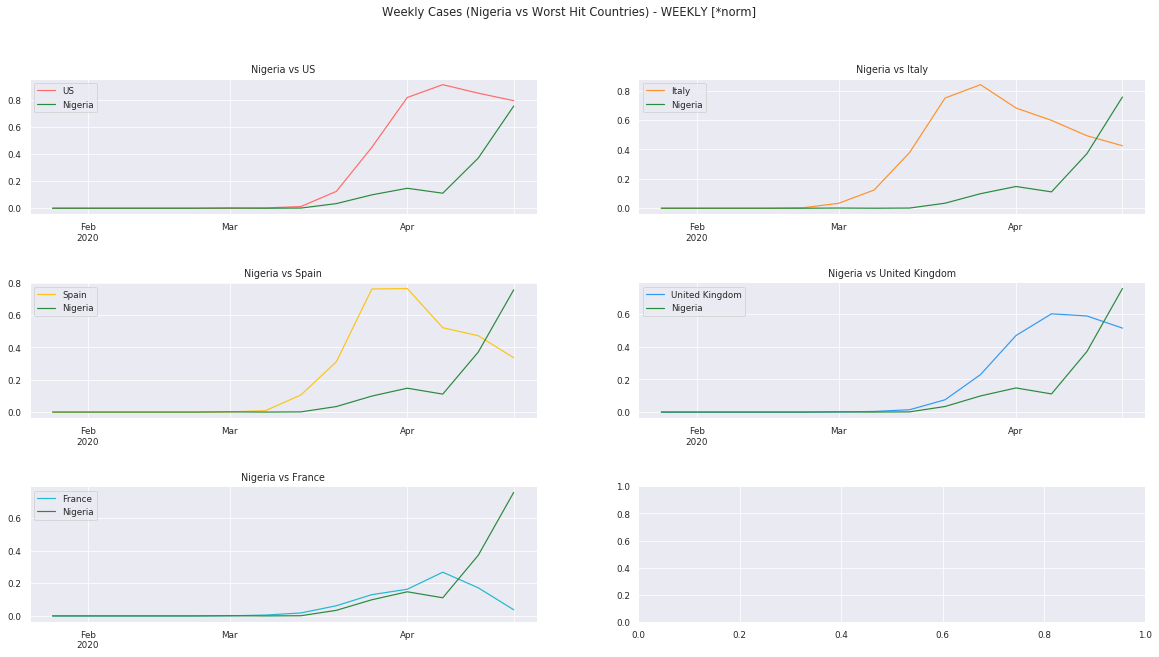

In [272]:
fig, axes = plt.subplots(3,2, figsize=(20,10))
axes = axes.ravel()
fig.subplots_adjust(hspace=0.5)

countries = worst_hit_covid
country_colors = ['#ff6b6b', '#ff922b', '#fcc419', '#339af0', '#22b8cf', '#f06595']
for country, ax in zip(zip(countries, country_colors), axes):
    df = countries[country[0]]
    df[['new_confirmed']].assign(norm=lambda x:normalize(x)).norm.resample('1W').mean().plot(kind='line', ax=ax, color=country[1], label=f'{country[0]}')
    covid_nigeria[['new_confirmed']].assign(norm=lambda x:normalize(x)).norm.resample('1W').mean().plot(kind='line', ax=ax, color='#2b8a3e', label='Nigeria')
    ax.legend()
    ax.set_xlabel('')
    ax.set_title(f'Nigeria vs {country[0]}')
plt.suptitle('Weekly Cases (Nigeria vs Worst Hit Countries) - WEEKLY [*norm]')
plt.savefig('weeklycases-norm vs worst - weekly')

## Growth Factor

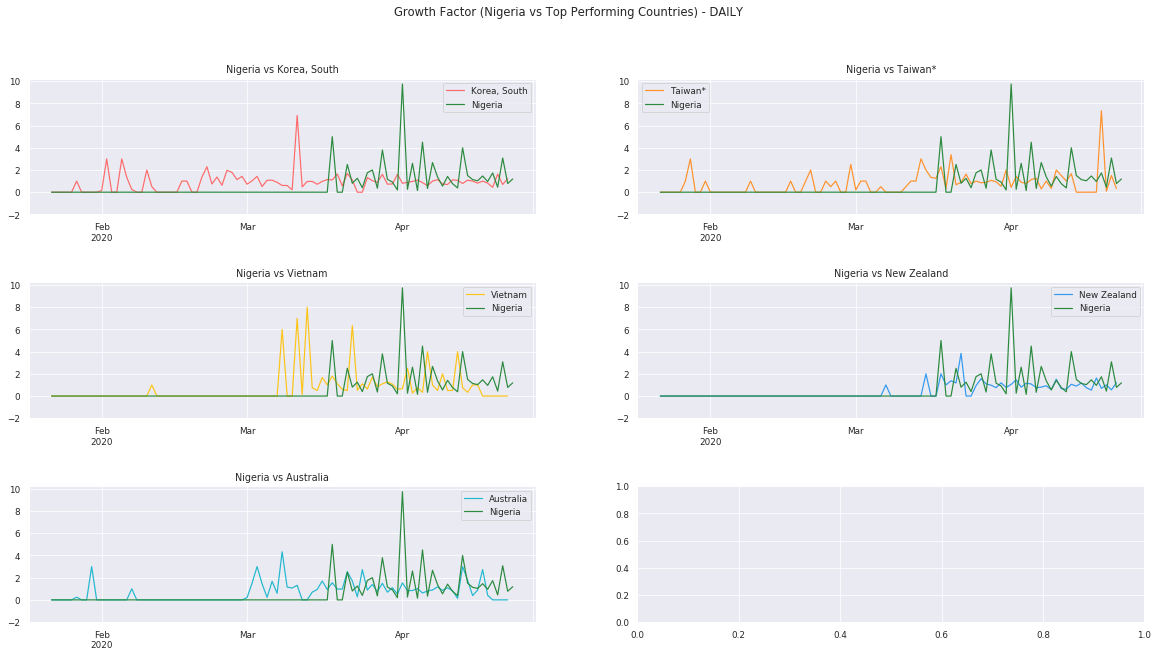

In [273]:
fig, axes = plt.subplots(3,2, figsize=(20,10))
fig.subplots_adjust(hspace=0.5)
axes = axes.ravel()
country_colors = ['#ff6b6b', '#ff922b', '#fcc419', '#339af0', '#22b8cf', '#f06595']
for country, ax in zip(zip(controlled_covid, country_colors), axes):
    df = controlled_covid[country[0]]
    df.growth_factor.plot(kind='line', ax=ax, color=country[1], label=f'{country[0]}')
    covid_nigeria.growth_factor.plot(kind='line', ax=ax, color='#2b8a3e', label='Nigeria')
    ax.set_ylim(-2,)
    ax.legend()
    ax.set_xlabel('')
    ax.set_title(f'Nigeria vs {country[0]}')
plt.suptitle('Growth Factor (Nigeria vs Top Performing Countries) - DAILY')
plt.savefig('growth-factor vs top - daily')

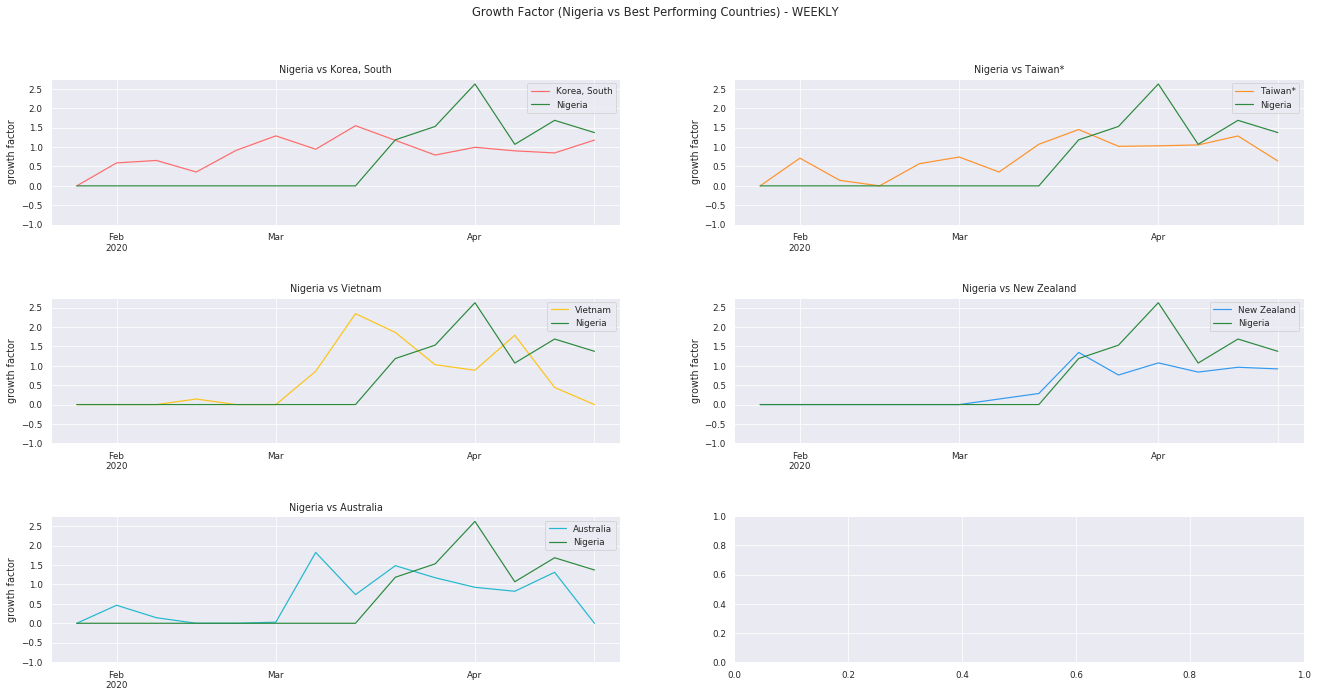

In [159]:
fig, axes = plt.subplots(3,2, figsize=(20,10))
axes = axes.ravel()
fig.subplots_adjust(hspace=0.5)
country_colors = ['#ff6b6b', '#ff922b', '#fcc419', '#339af0', '#22b8cf', '#f06595']
for country, ax in zip(zip(controlled_covid, country_colors), axes):
    df = controlled_covid[country[0]]
    df.growth_factor.resample('1W').mean().plot(kind='line', ax=ax, color=country[1], label=f'{country[0]}')
    covid_nigeria.growth_factor.resample('1W').mean().plot(kind='line', ax=ax, color='#2b8a3e', label='Nigeria')
    ax.set_ylim(-1,)
    ax.legend()
    ax.set_xlabel('')
    ax.set_ylabel('growth factor')
    ax.set_title(f'Nigeria vs {country[0]}')
plt.suptitle('Growth Factor (Nigeria vs Best Performing Countries) - WEEKLY')
plt.savefig('images/growth-factor vs top - weekly', bbox_inches='tight')

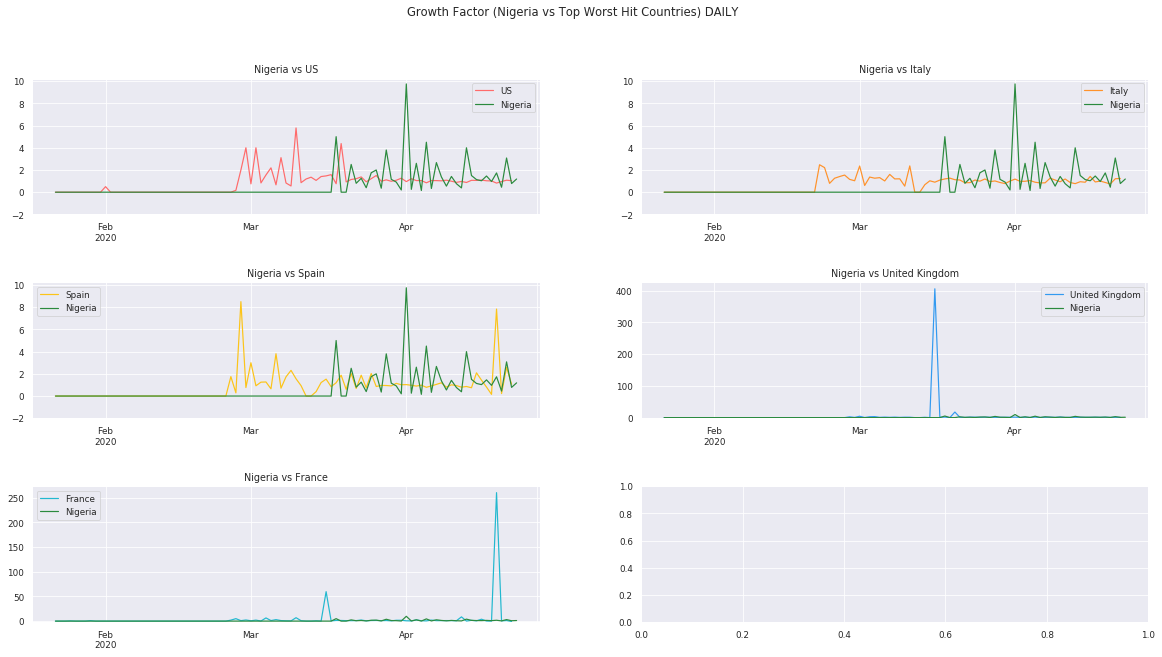

In [276]:
fig, axes = plt.subplots(3,2, figsize=(20,10))
fig.subplots_adjust(hspace=0.5)
axes = axes.ravel()
country_colors = ['#ff6b6b', '#ff922b', '#fcc419', '#339af0', '#22b8cf']
for country, ax in zip(zip(worst_hit_covid, country_colors), axes):
    df = worst_hit_covid[country[0]]
    df.growth_factor.plot(kind='line', ax=ax, color=country[1], label=f'{country[0]}')
    covid_nigeria.growth_factor.plot(kind='line', ax=ax, color='#2b8a3e', label='Nigeria')
    ax.set_ylim(-2,)
    ax.legend()
    ax.set_xlabel('')
    ax.set_title(f'Nigeria vs {country[0]}')
plt.suptitle('Growth Factor (Nigeria vs Top Worst Hit Countries) DAILY');
plt.savefig('growth-factor vs worst - daily')

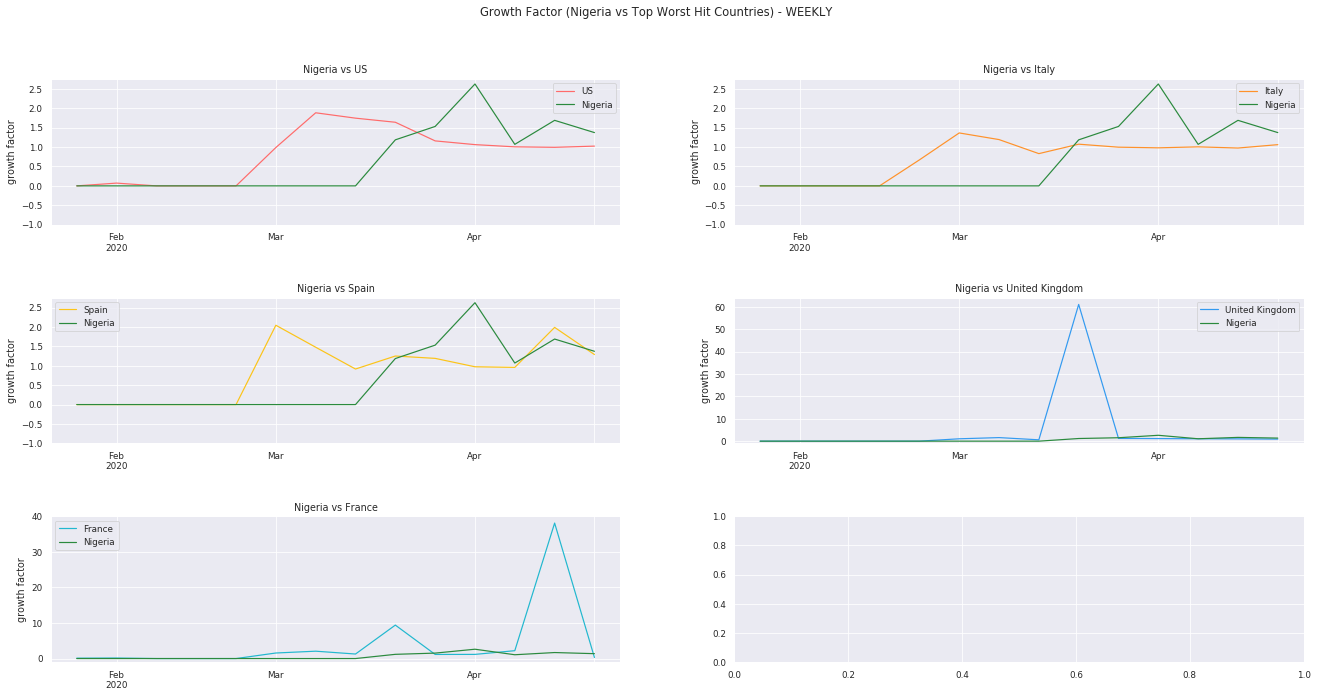

In [161]:
fig, axes = plt.subplots(3,2, figsize=(20,10))
fig.subplots_adjust(hspace=0.5)
axes = axes.ravel()
country_colors = ['#ff6b6b', '#ff922b', '#fcc419', '#339af0', '#22b8cf']
for country, ax in zip(zip(worst_hit_covid, country_colors), axes):
    df = worst_hit_covid[country[0]]
    df.growth_factor.resample('1W').mean().plot(kind='line', ax=ax, color=country[1], label=f'{country[0]}')
    covid_nigeria.growth_factor.resample('1W').mean().plot(kind='line', ax=ax, color='#2b8a3e', label='Nigeria')
    ax.set_ylim(-1,)
    ax.set_xlabel('')
    ax.set_ylabel('growth factor')
    ax.legend()
    ax.set_title(f'Nigeria vs {country[0]}')
plt.suptitle('Growth Factor (Nigeria vs Top Worst Hit Countries) - WEEKLY');
plt.savefig('images/growth-factor vs worst - weekly', bbox_inches='tight')

In [164]:
worst_hit_covid['United Kingdom']

,confirmed,new_confirmed,active,recovered,deaths,growth_factor,date_month_day
date,,,,,,,
2020-01-22,0,0,0,0,0,0.000000,Jan 22
2020-01-23,0,0,0,0,0,0.000000,Jan 23
2020-01-24,0,0,0,0,0,0.000000,Jan 24
2020-01-25,0,0,0,0,0,0.000000,Jan 25
2020-01-26,0,0,0,0,0,0.000000,Jan 26
2020-01-27,0,0,0,0,0,0.000000,Jan 27
2020-01-28,0,0,0,0,0,0.000000,Jan 28
2020-01-29,0,0,0,0,0,0.000000,Jan 29
2020-01-30,0,0,0,0,0,0.000000,Jan 30


## What is Nigeria doing different from the best recovered and similar to the worst hit

Google released a dataset called **[Community Mobility Report](https://www.google.com/covid19/mobility/)**, which is the same type of aggregated, anonymized insights used in Google Maps.   
These Community Mobility Reports aim to provide insights into what has changed in response to polices aimed at combating COVID-19.

Using this report I aim to identify patterns that exist in mobility of Nigeria, countries hit worst by the COVID-19 and those that seem to have gotten the virus under control

In [93]:
gm = pd.read_csv('./data/Global_Mobility_Report.csv', low_memory=False)

In [104]:
worst_hit = ['United States', 'Italy', 'Spain', 'United Kingdom', 'France']
best_hit = ['South Korea', 'Taiwan', 'Vietnam', 'New Zealand', 'Australia']
nig = 'Nigeria'

In [115]:
gm.head(1)

,country_region_code,country_region,sub_region_1,sub_region_2,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
0,AE,United Arab Emirates,NaN,NaN,2020-02-15,0.0,4.0,5.0,0.0,2.0,1.0


In [120]:
gm.loc[gm.country_region == nig].head()

,country_region_code,country_region,sub_region_1,sub_region_2,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
49501,NG,Nigeria,NaN,NaN,2020-02-15,3.0,1.0,7.0,3.0,5.0,0.0
49502,NG,Nigeria,NaN,NaN,2020-02-16,2.0,-1.0,5.0,0.0,3.0,0.0
49503,NG,Nigeria,NaN,NaN,2020-02-17,0.0,-2.0,2.0,0.0,3.0,1.0
49504,NG,Nigeria,NaN,NaN,2020-02-18,0.0,-5.0,0.0,0.0,2.0,0.0
49505,NG,Nigeria,NaN,NaN,2020-02-19,-2.0,-4.0,0.0,-2.0,1.0,1.0


In [149]:
def get_country_mobility(country):
    if country not in list(gm.country_region.unique()):
        raise KeyError(f'{country} not in Global Mobility Report; Use another name instead')
    df = gm.loc[gm.country_region == country].reset_index(drop=True)
    df = df.set_index(df.date)
    df.index = pd.to_datetime(df.index)
    df.sub_region_1 = df.sub_region_1.replace(np.nan, 'all')
    df = df.drop(['country_region_code', 'country_region', 'sub_region_2', 'date'], axis=1)
    df = df.rename(columns={'sub_region_1': 'sub_region'})
    return df
    

In [150]:
nigeria = get_country_mobility('Nigeria')

In [216]:
def plot_mobility_trend(country_name):
    country = get_country_mobility(country_name)    
    fig, axes = plt.subplots(3,2, figsize=(20,10))
    fig.subplots_adjust(hspace=1)
    axes = axes.ravel()

    categories = list(country.drop('sub_region', axis=1).columns)
    for category, ax in zip(categories, axes):
        avg = country.loc[country.sub_region == 'all'].drop('sub_region', axis=1)

        current_change = avg.iloc[-1].loc[category]
        category_name = ' '.join(category.split('_')).capitalize() 
        
        plot_name = f"{category_name}: {current_change:,.0f}%"

        avg.plot(y=category, ax=ax, legend=True, label=f'Average in {country_name.capitalize()}', title=plot_name)
        ax.set_ylim(-100,60)
        ax.axhline(y=0, linestyle='dotted', label='Baseline', color='k')
        ax.set_xlabel('Date')
        ax.legend()

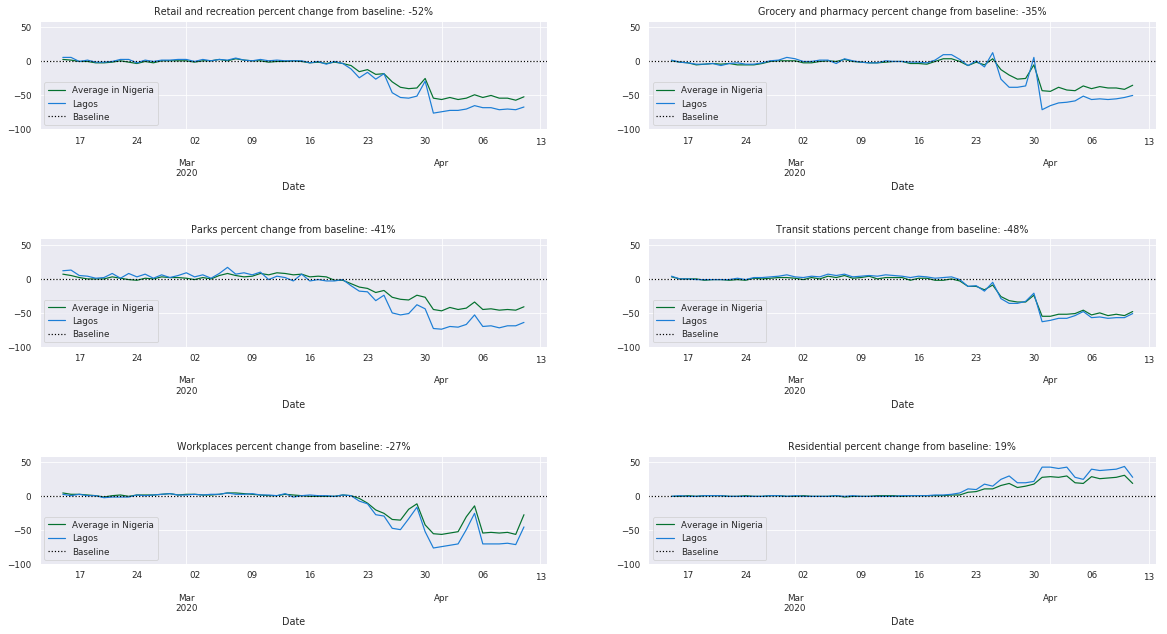

In [218]:
fig, axes = plt.subplots(3,2, figsize=(20,10))
fig.subplots_adjust(hspace=1)
axes = axes.ravel()

country_colors = ['#ff6b6b', '#ff922b', '#fcc419', '#339af0', '#22b8cf']
categories = list(nigeria.drop('sub_region', axis=1).columns)
for category, ax in zip(categories, axes):
    avg = nigeria.loc[nigeria.sub_region == 'all'].drop('sub_region', axis=1)
    lagos = nigeria.loc[nigeria.sub_region == 'Lagos'].drop('sub_region', axis=1)
    
    current_change = avg.iloc[-1].loc[category]
    category_name = ' '.join(category.split('_')).capitalize() 
    
    plot_name = f"{category_name}: {current_change:,.0f}%"
    
    avg.plot(y=category, ax=ax, legend=True, label='Average in Nigeria', title=plot_name)
    lagos.plot(y=category, ax=ax, color='#1c7ed6', label="Lagos")
    ax.set_ylim(-100,60)
    ax.axhline(y=0, linestyle='dotted', label='Baseline', color='k')
    ax.set_xlabel('Date')
    ax.legend()

Baseline refers to 

In [242]:
lagos = nigeria.loc[nigeria.sub_region == 'Lagos'].drop('sub_region', axis=1)

In [280]:
worst_hit = ['United States', 'Italy', 'Spain', 'United Kingdom', 'France']
best_hit = ['South Korea', 'Taiwan', 'Vietnam', 'New Zealand', 'Australia']

In [281]:
worst_hit_gm = {}
best_hit_gm = {}

for country in worst_hit:
    worst_hit_gm[country] = get_country_mobility(country)
    
for country in best_hit:
    best_hit_gm[country] = get_country_mobility(country)

In [283]:
italy = get_country_mobility('Italy')
us = get_country_mobility('United States')
sk = get_country_mobility('South Korea')
ta = get_country_mobility('Taiwan')

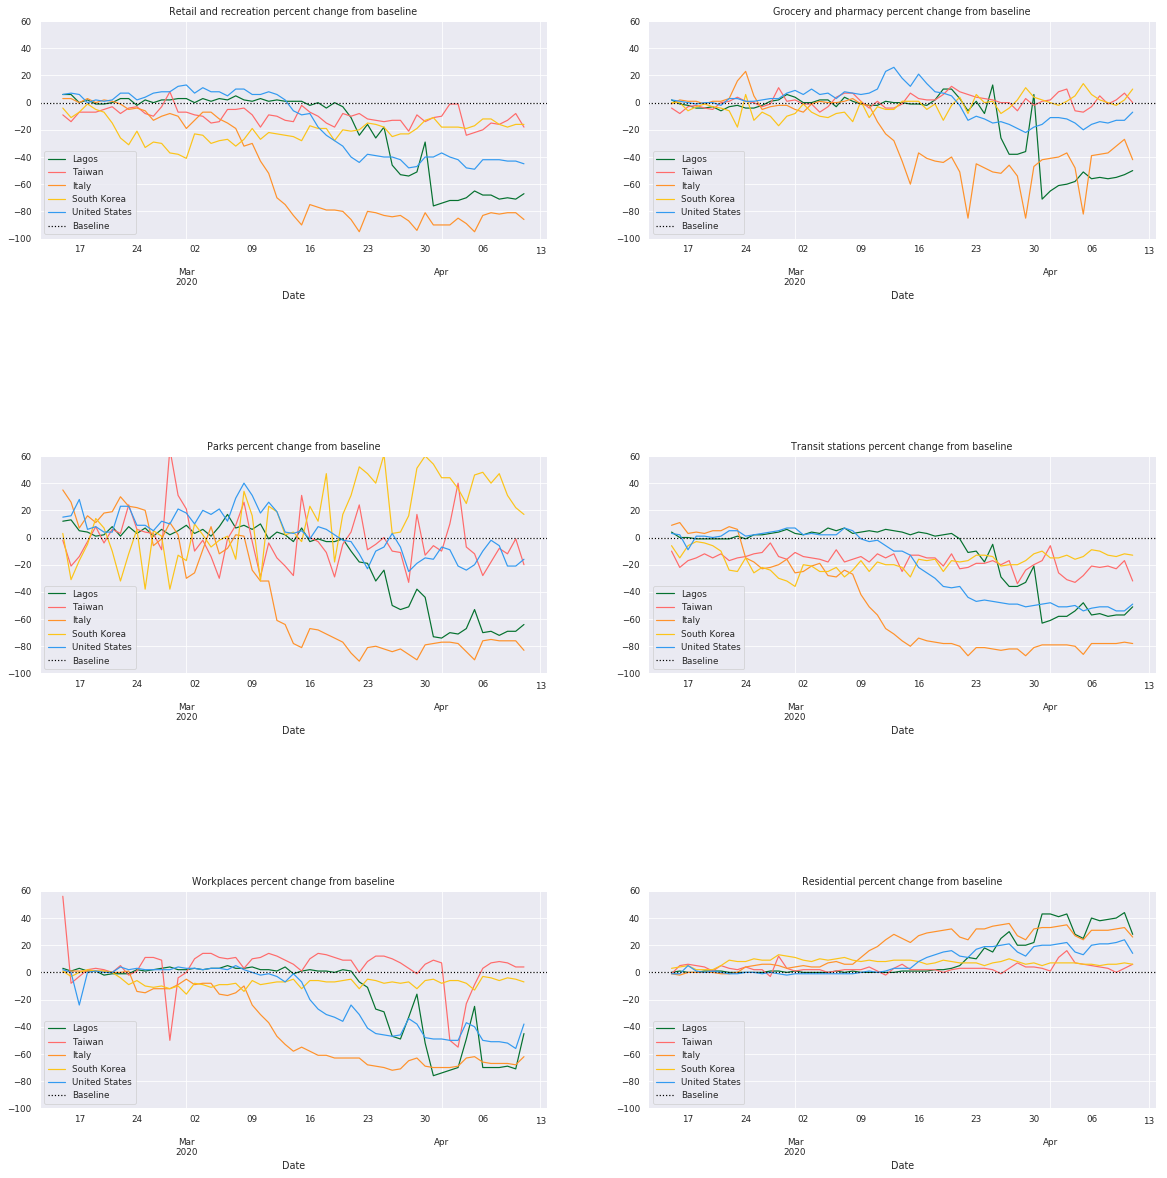

In [289]:
fig, axes = plt.subplots(3,2, figsize=(20,20))
fig.subplots_adjust(hspace=1)
axes = axes.ravel()
country_colors = ['#ff6b6b', '#ff922b', '#fcc419', '#339af0', '#22b8cf']
categories = list(nigeria.drop('sub_region', axis=1).columns)
for category, ax in zip(categories, axes):
    lagos = nigeria.loc[nigeria.sub_region == 'Lagos'].drop('sub_region', axis=1)
    tai_all = ta.loc[ta.sub_region == 'all'].drop('sub_region', axis=1)
    italy_all = italy.loc[italy.sub_region == 'all'].drop('sub_region', axis=1)
    sk_all = sk.loc[sk.sub_region == 'all'].drop('sub_region', axis=1)
    us_all = us.loc[us.sub_region == 'all'].drop('sub_region', axis=1)
    
    current_change = avg.iloc[-1].loc[category]
    category_name = ' '.join(category.split('_')).capitalize() 
    
    plot_name = f"{category_name}: {current_change:,.0f}%"
    
#     avg.plot(y=category, ax=ax, legend=True, label='Average in Nigeria', title=plot_name)
    lagos.plot(y=category, ax=ax, label="Lagos")
    tai_all.plot(y=category, ax=ax, label='Taiwan', color=country_colors[0])
    italy_all.plot(y=category, ax=ax, label='Italy', color=country_colors[1])
    sk_all.plot(y=category, ax=ax, label='South Korea', color=country_colors[2])
    us_all.plot(y=category, ax=ax, label="United States", color=country_colors[3])
    ax.set_ylim(-100,60)
    ax.axhline(y=0, linestyle='dotted', label='Baseline', color='k')
    ax.set_xlabel('Date')
    ax.set_title(category_name)
    ax.legend()